1. create folder in local runtime
2. upload dataset zip to local runtime
3. unzip

In [ ]:
!unzip /content/dataset_cropped_224x224_newest.zip -d /content/dataset_cropped_224x224_newest

Archive:  /content/dataset_cropped_224x224_newest-20251128T144454Z-1-001.zip
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/b--50-_jpg.rf.fa7945cbc17bad7cb2a6f51a138c0b99_tile1.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/125_jpg.rf.f37f515011dff4fbb0b882e824432b93_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/a--32-_jpg.rf.f7a6bf6256f4a4bc417a23dd47536c7f_tile1.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/a--87-_jpg.rf.e99dd21bd33d8f9c6b36c8d8b908f5f8_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/c--142-_jpg.rf.fb5f460875d029f6681a6b655358776e_tile2.jpg  
  inflating: /content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train/156_jpg.rf.746421f245b72dbf541074bf5d373bdd_tile0.jpg  
  inflating: /content/dataset_crop

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.4 MB/s eta 0:00:00


In [ ]:
import os
import time
import torch
import cv2
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

import albumentations as A
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [ ]:
thop_available = False
try:
    # Check if thop is installed, if not, install it
    import importlib.util
    if not importlib.util.find_spec("thop"):
        print("Installing thop...")
        !pip install thop
        import thop # Re-import after installation attempt
    from thop import profile
    thop_available = True
except Exception as e:
    print(f"THOP library import failed: {e}")
    thop_available = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class MicroplasticsDataset(Dataset):
    def __init__(self, df, images_dir, transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.transforms = transforms
        self.image_files = df['filename'].unique().tolist()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        records = self.df[self.df['filename'] == img_file]
        boxes = records[['xmin','ymin','xmax','ymax']].values
        labels = records['label'].values

        if self.transforms:
            aug = self.transforms(image=img, bboxes=boxes, class_labels=labels)
            img = aug['image']
            boxes = aug['bboxes']
            labels = aug['class_labels']

        img_tensor = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        return img_tensor, {"boxes": boxes_tensor, "labels": labels_tensor}


def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

crop_train_dir = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/train"
crop_val_dir   = "/content/dataset_cropped_224x224_newest/dataset_cropped_224x224_newest/valid"

train_df = pd.read_csv(os.path.join(crop_train_dir, "_annotations.csv"))
val_df   = pd.read_csv(os.path.join(crop_val_dir, "_annotations.csv"))

# encodings
unique_classes = sorted(train_df['class'].unique())
class_to_idx = {cls: idx+1 for idx, cls in enumerate(unique_classes)}

train_df["label"] = train_df["class"].map(class_to_idx)
val_df["label"]   = val_df["class"].map(class_to_idx)

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_dataset = MicroplasticsDataset(train_df, crop_train_dir, transforms=train_transforms)
val_dataset   = MicroplasticsDataset(val_df, crop_val_dir, transforms=None)

# Increased val_loader batch_size from 1 to 16 for faster validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  collate_fn=collate_fn, num_workers=1)
val_loader   = DataLoader(val_dataset,   batch_size=1,  shuffle=False, collate_fn=collate_fn, num_workers=1)

print(f"Loaded {len(train_dataset)} train and {len(val_dataset)} validation images.")

Using device: cuda
Loaded 1869 train and 647 validation images.


In [ ]:
import os

train_files_fs = [f for f in os.listdir(crop_train_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
val_files_fs   = [f for f in os.listdir(crop_val_dir)   if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print("train images on disk:", len(train_files_fs))
print("val images on disk:",   len(val_files_fs))
print("total on disk:",        len(train_files_fs) + len(val_files_fs))

print("train in CSV:", train_df["filename"].nunique())
print("val in CSV:",   val_df["filename"].nunique())

train images on disk: 2308
val images on disk: 816
total on disk: 3124
train in CSV: 1869
val in CSV: 647


# Model Setup

## SE Blocks

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        mid = max(channels // reduction, 1)
        self.fc = nn.Sequential(
            nn.Linear(channels, mid, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avgpool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [ ]:
class CustomCNNBackboneSE(nn.Module):
    def __init__(self, channels=(32, 64, 128, 256), se_reduction=16):
        super().__init__()
        self.blocks = nn.ModuleList()
        self.pools  = nn.ModuleList()

        in_ch = 3
        for ch in channels:
            block = nn.Sequential(
                nn.Conv2d(in_ch, ch, 3, 1, 1),
                nn.BatchNorm2d(ch),
                nn.ReLU(),
                nn.Conv2d(ch, ch, 3, 1, 1),
                nn.BatchNorm2d(ch),
                nn.ReLU(),
                SEBlock(channels=ch, reduction=se_reduction),
            )
            self.blocks.append(block)
            self.pools.append(nn.MaxPool2d(2))
            in_ch = ch

        self.out_channels = channels[-1]
        self.channels = channels
        self.se_reduction = se_reduction

    def forward(self, x):
        for block, pool in zip(self.blocks, self.pools):
            x = pool(block(x))
        return x

In [ ]:
def build_model_se(channels=(32, 64, 128, 256), se_reduction=16):
    backbone = CustomCNNBackboneSE(channels=channels, se_reduction=se_reduction)
    anchor_generator = AnchorGenerator(
        sizes=((16, 32, 64, 128, 256),),
        aspect_ratios=((0.5, 1.0, 2.0),),
    )

    model = FasterRCNN(
        backbone,
        num_classes=len(unique_classes) + 1,
        rpn_anchor_generator=anchor_generator,
        min_size=224,
        max_size=224,
        image_mean=[0.0, 0.0, 0.0],
        image_std=[1.0, 1.0, 1.0],
    ).to(device)
    return model

In [ ]:
def run_se_experiment(channels=(32, 64, 128, 256),
                      se_reduction=16,
                      num_epochs=30,
                      tag="customcnn_depth4_se"):

    model = build_model_se(channels=channels, se_reduction=se_reduction)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    metric = MeanAveragePrecision().to(device)

    history = []
    print(f"\nExperiment {tag}, channels={channels}, blocks={len(channels)}, SE reduction={se_reduction}")
    train_start_time = time.time()

    base_results_dir = "/models"
    os.makedirs(base_results_dir, exist_ok=True)

    experiment_dir = os.path.join(base_results_dir, tag)
    os.makedirs(experiment_dir, exist_ok=True)

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for images, targets in train_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            losses = model(images, targets)
            total_loss = sum(losses.values())
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        scheduler.step()
        epoch_loss_avg = epoch_loss / len(train_loader)

        model.eval()
        metric.reset()
        with torch.no_grad():
            for images, targets in val_loader:
                images  = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images)
                metric.update(preds, targets)

        m = metric.compute()
        map_50    = float(m["map_50"])
        map_50_95 = float(m["map"])

        history.append({
            "epoch": epoch,
            "loss": epoch_loss_avg,
            "mAP_50": map_50,
            "mAP_50_95": map_50_95,
        })

        print(
            f"Epoch {epoch:02d}: "
            f"loss={epoch_loss_avg:.4f}, "
            f"mAP@50={map_50:.3f}, "
            f"mAP@50:95={map_50_95:.3f}"
        )

    torch.save(model.state_dict(), os.path.join(experiment_dir, f"{tag}_final.pth"))

    total_time = time.time() - train_start_time
    print(f"Training completed in {total_time/60:.2f} min.")

    df_hist = pd.DataFrame(history)
    df_hist.to_csv(os.path.join(experiment_dir, f"{tag}_history.csv"), index=False)

    macs = None
    if thop_available:
        try:
            from thop import profile
            model.eval()
            dummy_input = torch.randn(1, 3, 224, 224).to(device)
            macs, _ = profile(model, inputs=(dummy_input,), verbose=False)
            print(f"MACs: {macs/1e9:.2f} G")
        except Exception as e:
            print(f"MACs estimation failed: {e}")
            macs = None
    else:
        print("THOP not available, MACs not computed.")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total params: {total_params/1e6:.2f} M")

    model.eval()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    inf_start = time.time()
    total_images = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = [img.to(device) for img in images]
            _ = model(images)
            total_images += len(images)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    inf_end = time.time()

    avg_inf_time = (inf_end - inf_start) / max(total_images, 1)
    fps = 1.0 / avg_inf_time if avg_inf_time > 0 else 0.0
    print(f"Avg inference: {avg_inf_time*1000:.2f} ms/img, FPS={fps:.2f}")

    summary = {
        "model_tag": tag,
        "channels": channels,
        "num_blocks": len(channels),
        "se_reduction": se_reduction,
        "total_train_time_sec": total_time,
        "best_mAP_50": float(df_hist["mAP_50"].max()),
        "best_mAP_50_95": float(df_hist["mAP_50_95"].max()),
        "inference_time_sec": avg_inf_time,
        "FPS": fps,
        "MACs_G": macs/1e9 if macs is not None else None,
        "params_M": total_params/1e6,
    }
    return df_hist, summary

In [ ]:
se_configs = [4, 8, 16]

se_summaries = []
se_histories = {}

for r in se_configs:
    tag = f"customcnn_depth4_se_r{r}"
    df_hist, summary = run_se_experiment(
        channels=(32, 64, 128, 256),  # best depth config
        se_reduction=r,
        num_epochs=30,
        tag=tag,
    )
    se_histories[r] = df_hist
    se_summaries.append(summary)

df_se_results = pd.DataFrame(se_summaries)
print(df_se_results)


Experiment customcnn_depth4_se_r4, channels=(32, 64, 128, 256), blocks=4, SE reduction=4
Epoch 01: loss=0.2520, mAP@50=0.128, mAP@50:95=0.036
Epoch 02: loss=0.1971, mAP@50=0.280, mAP@50:95=0.085
Epoch 03: loss=0.1889, mAP@50=0.348, mAP@50:95=0.112
Epoch 04: loss=0.1852, mAP@50=0.435, mAP@50:95=0.149
Epoch 05: loss=0.1766, mAP@50=0.457, mAP@50:95=0.154
Epoch 06: loss=0.1672, mAP@50=0.517, mAP@50:95=0.180
Epoch 07: loss=0.1697, mAP@50=0.543, mAP@50:95=0.202
Epoch 08: loss=0.1657, mAP@50=0.585, mAP@50:95=0.217
Epoch 09: loss=0.1646, mAP@50=0.588, mAP@50:95=0.216
Epoch 10: loss=0.1623, mAP@50=0.588, mAP@50:95=0.219
Epoch 11: loss=0.1521, mAP@50=0.635, mAP@50:95=0.244
Epoch 12: loss=0.1493, mAP@50=0.637, mAP@50:95=0.249
Epoch 13: loss=0.1464, mAP@50=0.641, mAP@50:95=0.253
Epoch 14: loss=0.1466, mAP@50=0.655, mAP@50:95=0.260
Epoch 15: loss=0.1479, mAP@50=0.655, mAP@50:95=0.258
Epoch 16: loss=0.1431, mAP@50=0.664, mAP@50:95=0.264
Epoch 17: loss=0.1435, mAP@50=0.668, mAP@50:95=0.271
Epoch 18:

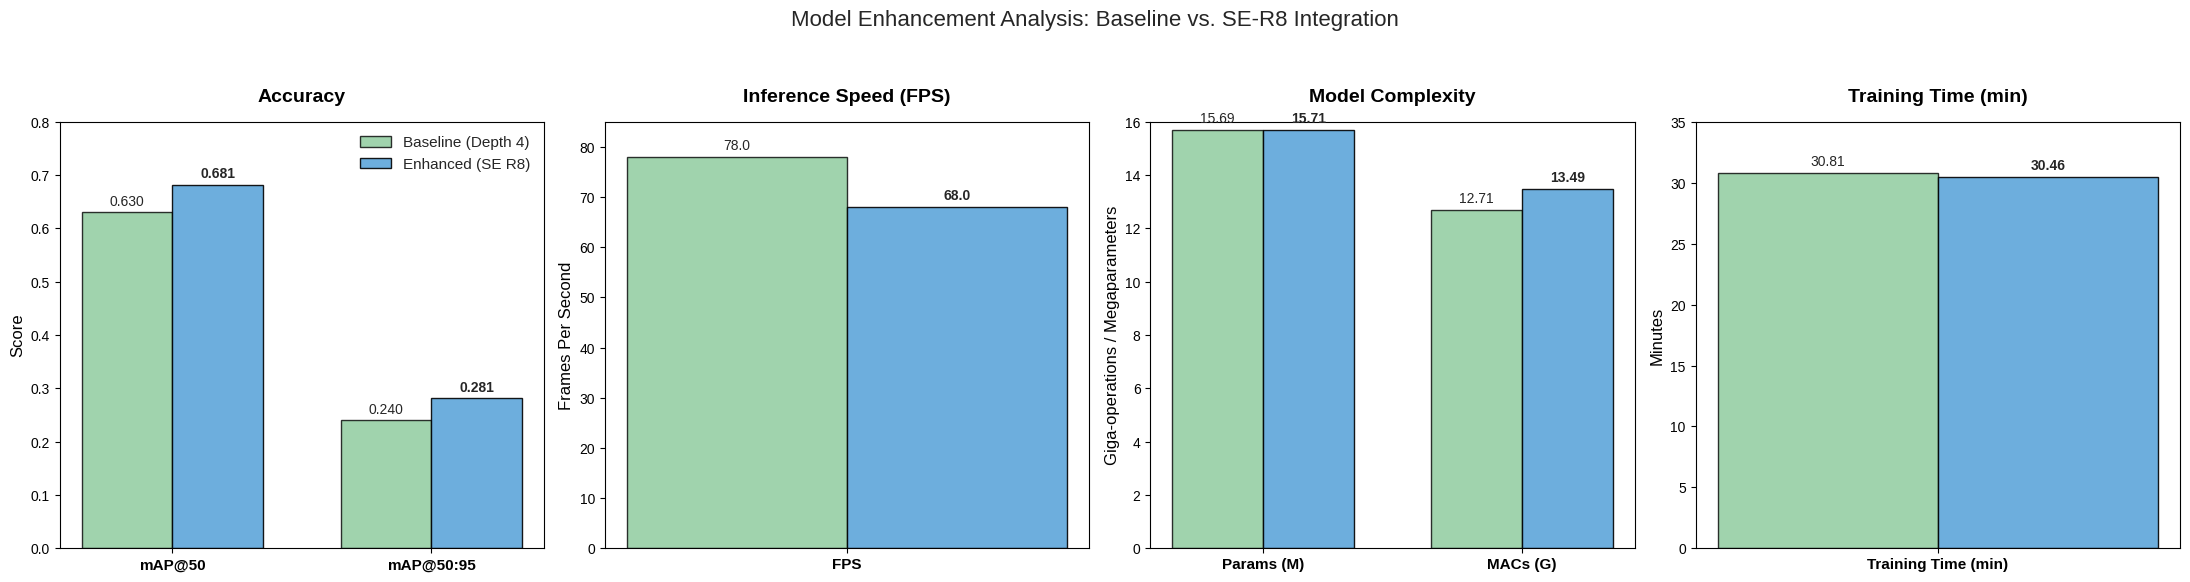

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- DATA PREPARATION ---
# Baseline: CNN Depth 4
# Enhanced: CustomCNN SE R8

metrics = {
    'mAP@50':     {'Baseline': 0.63,   'Enhanced': 0.6812},
    'mAP@50:95':  {'Baseline': 0.24,   'Enhanced': 0.281},
    'FPS':        {'Baseline': 78,     'Enhanced': 68.0},
    'Params (M)': {'Baseline': 15.69,  'Enhanced': 15.71},
    'MACs (G)':   {'Baseline': 12.71,  'Enhanced': 13.49},
    'Training Time (min)': {'Baseline': 30.81, 'Enhanced': 30.46} # Training Time added
}

# Grouping metrics for subplots (4 groups now)
groups = [
    ['mAP@50', 'mAP@50:95'],
    ['FPS'],
    ['Params (M)', 'MACs (G)'],
    ['Training Time (min)'] # New group
]

group_titles = [
    'Accuracy',
    'Inference Speed (FPS)',
    'Model Complexity',
    'Training Time (min)' # New title
]

# --- PLOTTING ---
# Changed layout to 1 row, 4 columns (1, 4) and increased figsize
fig, axes = plt.subplots(1, 4, figsize=(22, 5.5))
plt.style.use('seaborn-v0_8-whitegrid')

bar_width = 0.35
colors = ['#88c999', '#5da5da'] # Soft Green (Baseline), Soft Blue (Enhanced)

for i, (ax, metric_group) in enumerate(zip(axes, groups)):

    x = np.arange(len(metric_group))
    baseline_vals = [metrics[m]['Baseline'] for m in metric_group]
    enhanced_vals = [metrics[m]['Enhanced'] for m in metric_group]

    # Create bars
    rects1 = ax.bar(x - bar_width/2, baseline_vals, bar_width, label='Baseline (Depth 4)', color=colors[0], edgecolor='black', alpha=0.8)
    rects2 = ax.bar(x + bar_width/2, enhanced_vals, bar_width, label='Enhanced (SE R8)', color=colors[1], edgecolor='black', alpha=0.9)

    # Formatting
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_group, fontsize=11, fontweight='bold')

    # Add legend to the first plot
    if i == 0:
        ax.legend(fontsize=11)

    # Specific Y-labeling and scale adjustment based on group index (i)
    if i == 0: # Accuracy
        ax.set_ylabel('Score', fontsize=12)
        ax.set_ylim(0, 0.8)
        fmt_str = '%.3f'
    elif i == 1: # FPS
        ax.set_ylabel('Frames Per Second', fontsize=12)
        ax.set_ylim(0, 85) # Adjusted limit
        fmt_str = '%.1f'
    elif i == 2: # Complexity
        ax.set_ylabel('Giga-operations / Megaparameters', fontsize=12)
        ax.set_ylim(0, 16) # Adjusted limit based on max 13.49
        fmt_str = '%.2f'
    elif i == 3: # Training Time
        ax.set_ylabel('Minutes', fontsize=12)
        ax.set_ylim(0, 35) # Adjusted limit
        fmt_str = '%.2f'

    # Add value labels
    ax.bar_label(rects1, padding=3, fmt=fmt_str, fontsize=10)
    ax.bar_label(rects2, padding=3, fmt=fmt_str, fontsize=10, fontweight='bold')

plt.suptitle('Model Enhancement Analysis: Baseline vs. SE-R8 Integration', fontsize=16, y=1.05)
plt.tight_layout()

# Save the plot
plt.savefig('./results/cnn_se_r8_comparison_full.png')